In [1]:
%pylab inline

from utils import RLEnvironment, RLDebugger

import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

Populating the interactive namespace from numpy and matplotlib


In [2]:
env = RLEnvironment()
print(env.observation_space, env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(4,) Discrete(2)


## Random agent

In [3]:
class RandomAgent:
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def get_action(self, state):
        return self.action_space.sample()

## Play loop
Note that this Gym environment is considered as solved as soon as you find a policy which scores 200 on average.

Episode 10, Reward 20.0
Episode 20, Reward 11.0
Average Reward of last 20 episodes: 21.05


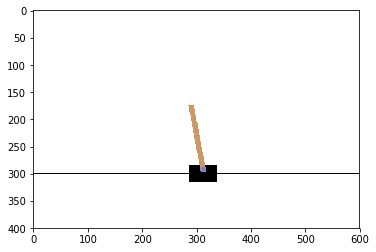

In [5]:
env.run(RandomAgent(env.action_space), episodes=20, display_policy=True)


## DQN Agent - Online
Here is a keras code for training a simple DQN. 

It is presented first for the sake of clarity. Nevertheless, the trained network is immediatly used to collect the new training data, unless you are lucky you won't be able to find a way to solve the task. 

Just replace the `???` by some parameters which seems reasonnable to you ($\gamma>1$ is not reasonnable and big steps are prone to numerical instability) and watch the failure of the policy training. 

In [3]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 30)
        self.fc2 = nn.Linear(30, output_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return self.fc2(x)

In [4]:
class DQNAgent(RLDebugger):
    def __init__(self, observation_space, action_space):
        RLDebugger.__init__(self)
        # get size of state and action
        self.state_size = observation_space.shape[0]
        self.action_size = action_space.n
        # hyper parameters 
        self.gamma = .995
        self.learning_rate = .01
        self.build_model()  
        self.target_model = self.model
        
    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        self.model = Model(input_dim=self.state_size, output_dim=self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss = nn.MSELoss()
        # 1/ You can try different losses. As an logcosh loss is a twice differenciable approximation of Huber loss
        # 2/ From a theoretical perspective Learning rate should decay with time to guarantee convergence 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float()
        q_value = self.model(state).detach().numpy()
        best_action = np.argmax(q_value[0]) #The [0] is because keras outputs a set of predictions of size 1
        return int(best_action)
    
    # train the target network on the selected action and transition
    def train_model(self, action, state, next_state, reward, done):
        state = torch.from_numpy(state).float()
        next_state = torch.from_numpy(next_state).float()
        
        val = self.model(state)[0][action]
        target = self.model(state)
        target_val = self.target_model(next_state)
        
        if done: #We are on a terminal state
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * (torch.max(target_val))
        
        # and do the model fit!
        self.model.zero_grad()
        loss = self.loss(val, target.detach()[0][action])
        loss.backward()
        self.optimizer.step()
        self.record(action, state, target, target_val, loss, reward)

In [5]:
agent = DQNAgent(env.observation_space, env.action_space)
env.run(agent, episodes=500)

Episode 10, Reward 10.0
Episode 20, Reward 12.0
Episode 30, Reward 14.0
Episode 40, Reward 16.0
Episode 50, Reward 22.0
Episode 60, Reward 38.0
Episode 70, Reward 40.0
Episode 80, Reward 48.0
Episode 90, Reward 36.0
Episode 100, Reward 81.0
Episode 110, Reward 53.0
Episode 120, Reward 46.0
Episode 130, Reward 43.0
Episode 140, Reward 59.0
Episode 150, Reward 68.0
Episode 160, Reward 38.0
Episode 170, Reward 200.0
Episode 180, Reward 200.0
Episode 190, Reward 200.0
Episode 200, Reward 200.0
Episode 210, Reward 185.0
Episode 220, Reward 200.0
Episode 230, Reward 200.0
Episode 240, Reward 200.0
Episode 250, Reward 200.0
Episode 260, Reward 171.0
Episode 270, Reward 200.0
Episode 280, Reward 78.0
********************************************************************************
CONGRATS !!! YOU JUST SOLVED CARTPOLE !!!
********************************************************************************
now you can try with envname='MsPacman-ram' ;)
Average Reward of last 100 episodes: 191.32


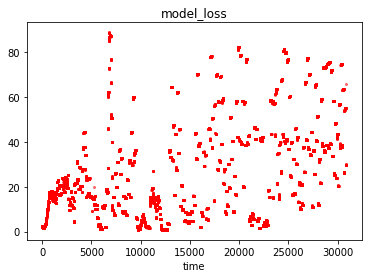

In [10]:
agent.plot_loss()

### Let's try with a fixed initial position

In [11]:
agent = DQNAgent(env.observation_space, env.action_space)
env.run(agent, episodes=300, seed=0)

Episode 10, Reward 10.0
Episode 20, Reward 10.0
Episode 30, Reward 10.0
Episode 40, Reward 10.0
Episode 50, Reward 10.0
Episode 60, Reward 10.0
Episode 70, Reward 10.0
Episode 80, Reward 10.0
Episode 90, Reward 10.0
Episode 100, Reward 10.0
Episode 110, Reward 10.0
Episode 120, Reward 10.0
Episode 130, Reward 10.0
Episode 140, Reward 10.0
Episode 150, Reward 10.0
Episode 160, Reward 10.0
Episode 170, Reward 10.0
Episode 180, Reward 10.0
Episode 190, Reward 10.0
Episode 200, Reward 10.0
Episode 210, Reward 10.0
Episode 220, Reward 10.0
Episode 230, Reward 10.0
Episode 240, Reward 10.0
Episode 250, Reward 10.0
Episode 260, Reward 10.0
Episode 270, Reward 10.0
Episode 280, Reward 10.0
Episode 290, Reward 10.0
Episode 300, Reward 10.0
Average Reward of last 100 episodes: 10.0


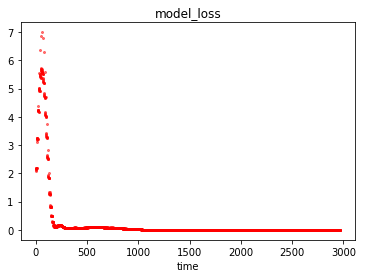

In [12]:
agent.plot_loss()

## DQN Agent with Exploration
This is our first agent which is going to solve the task. It will typically require to run a few hundred of episodes to collect the data. 

The difference with the previous agent is that you are going to add an exploration mechanism in order to take care of the data collection for the training. We advise to use an $\varepsilon_n$-greedy, meaning that the value of $\varepsilon$ is going to decay over time. Several kind of decays can be found in the litterature, a simple one is to use a mutiplicative update of $\varepsilon$ by a constant smaller than 1 as long as $\varepsilon$ is smaller than a small minimal rate (typically in the range 1%-5%).

You need to:
* Code your exploration (area are tagged in the code by some TODOs).
* Tune the hyperparameters (including the ones from the previous section) in order to solve the task. This may be not so easy and will likely require more than 500 episodes and a final small value of epsilon. Next sessions will be about techniques to increase sample efficiency (i.e require less episodes).

In [6]:
class DQNAgentWithExploration(DQNAgent):
    def __init__(self, observation_space, action_space):
        super(DQNAgentWithExploration, self).__init__(observation_space, action_space)
        # exploration schedule parameters 
        self.t = 0
        self.epsilon = 0.5 # Designs the probability of taking a random action. 
                           # Should be in range [0,1]. The closer to 0 the greedier. 
                           # Hint: start close to 1 (exploration) and end close to zero (exploitation).

    # decay epsilon
    def update_epsilon(self):
        # TODO write the code for your decay
        self.t += 1
        self.epsilon = self.epsilon * 0.99

    # get action from model using greedy policy
    def get_action(self, state):
        # exploration 
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        state = torch.from_numpy(state).float()
        q_value = self.model(state).detach().numpy()
        best_action = np.argmax(q_value[0])
        return int(best_action)

In [7]:
agent = DQNAgentWithExploration(env.observation_space, env.action_space)
env.run(agent, episodes=500, print_delay=50, seed=0)

Episode 50, Reward 16.0, Epsilon 0.0007497921840408691
Episode 100, Reward 46.0, Epsilon 2.5770549009964414e-11
Episode 150, Reward 40.0, Epsilon 5.464708912157767e-28
Episode 200, Reward 199.0, Epsilon 4.061570806426135e-61
Episode 250, Reward 200.0, Epsilon 3.3751528580758635e-95
Episode 300, Reward 200.0, Epsilon 7.589958861526495e-139
********************************************************************************
CONGRATS !!! YOU JUST SOLVED CARTPOLE !!!
********************************************************************************
now you can try with envname='MsPacman-ram' ;)
Average Reward of last 100 episodes: 190.12


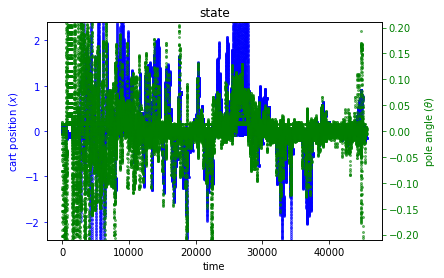

In [18]:
agent.plot_state()

## DQN Agent with Exploration and Experience Replay

We are now going to save some samples in a limited memory in order to build minibatches during the training. The exploration policy remains the same than in the previous section.  Storage is already coded you just need to modify the tagged section which is about building the mini-batch sent to the optimizer.

In [8]:
from collections import deque

class DQNAgentWithExplorationAndReplay(DQNAgentWithExploration):
    def __init__(self, observation_space, action_space):
        super(DQNAgentWithExplorationAndReplay, self).__init__(observation_space, action_space)
        self.batch_size = 30 # Recommended value range [10, 1000]
        # create replay memory using deque
        self.memory = deque(maxlen=10000) # Recommended value range [10, 20000]

    def create_minibatch(self):
        # pick samples randomly from replay memory (using batch_size)
        
        batch_size = min(self.batch_size, len(self.memory))
        samples = random.sample(self.memory, batch_size)
        
        states = np.array([_[0][0] for _ in samples])
        actions = np.array([_[1] for _ in samples])
        rewards = np.array([_[2] for _ in samples])
        next_states = np.array([_[3][0] for _ in samples])
        dones = np.array([_[4] for _ in samples])
        
        return (states, actions, rewards, next_states, dones)
        
    def train_model(self, action, state, next_state, reward, done):
        
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
        
        if len(self.memory) >= self.batch_size:
            states, actions, rewards, next_states, dones = self.create_minibatch()
            
            states = torch.from_numpy(states).float()
            next_states = torch.from_numpy(next_states).float()

            vals = self.model(states).gather(1,torch.from_numpy(actions).view(-1,1))
            targets = self.model(states)
            targets_val = self.target_model(next_states).detach()
            
            for i in range(self.batch_size):
                # Approx Q Learning
                if dones[i]:
                    targets[i][actions[i]] = rewards[i]
                else:
                    targets[i][actions[i]] = rewards[i] + self.gamma * (torch.max(targets_val[i]))
           
            # and do the model fit!
            self.model.zero_grad()
            loss = self.loss(vals, targets.detach().gather(1,torch.from_numpy(actions).view(-1,1)))
            loss.backward()
            self.optimizer.step()
            
            for i in range(self.batch_size):
                self.record(actions[i], states[i], targets[i], targets_val[i], loss / self.batch_size, rewards[i])

In [9]:
agent = DQNAgentWithExplorationAndReplay(env.observation_space, env.action_space)
env.run(agent, episodes=300, print_delay=50)

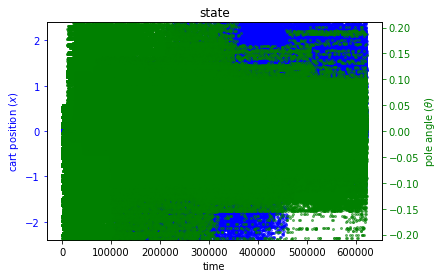

In [61]:
agent.plot_state()

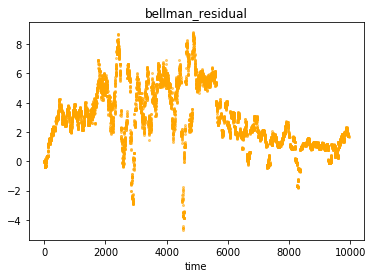

In [62]:
agent.plot_bellman_residual()

## Double DQN Agent with Exploration and Experience Replay

Now we want to have two identical networks and keep frozen for some timesteps the one which is in charge of the evaluation (*i.e* which is used to compute the targets).
Note that you can find some variants where the target network is updated at each timestep but with a small fraction of the difference with the policy network.

In [10]:
class DoubleDQNAgentWithExplorationAndReplay(DQNAgentWithExplorationAndReplay):
    def __init__(self, observation_space, action_space):
        super(DoubleDQNAgentWithExplorationAndReplay, self).__init__(observation_space, action_space)
        # TODO: initialize a second model
        self.target_model = Model(input_dim=self.state_size, output_dim=self.action_size)

    def update_target_model(self):
        # copy weights from the model used for action selection to the model used for computing targets
        self.target_model.load_state_dict(self.model.state_dict())

In [11]:
agent = DoubleDQNAgentWithExplorationAndReplay(env.observation_space, env.action_space)
env.run(agent, episodes=300, print_delay=10)

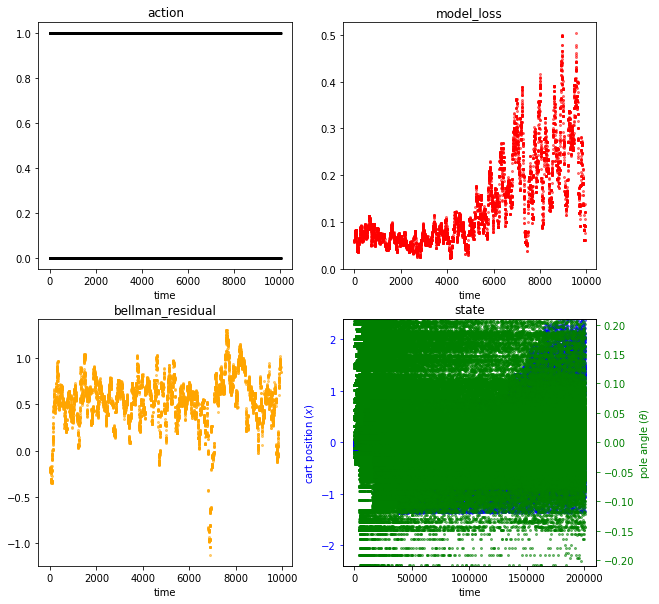

In [12]:
agent.plot_diagnostics()

To observe actual performance of the policy we should set $\varepsilon=0$

In [12]:
agent.epsilon = 0
agent.memory = deque(maxlen=1)
agent.batch_size = 1
env.run(agent, episodes=300, print_delay=33)

Episode 33, Reward 74.0, Epsilon 0.0
Average Reward of last 50 episodes: 21.18


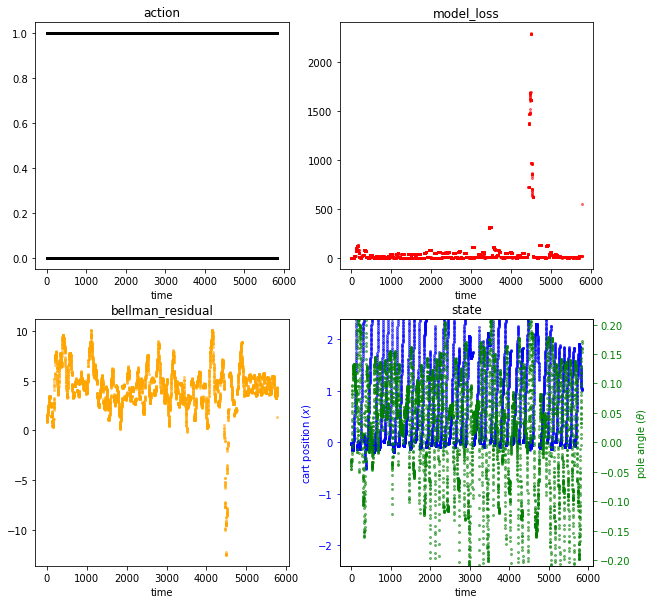

In [14]:
agent.plot_diagnostics()

## Duelling DQN 

If time allows, adapt the description from http://torch.ch/blog/2016/04/30/dueling_dqn.html to our setting

In [13]:
class DuelingModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingModel, self).__init__()
        self.action_dim = output_dim
        self.value_fc1 = nn.Linear(input_dim, 30)
        self.value_fc2 = nn.Linear(30, 1)
        
        self.advantage_fc1 = nn.Linear(input_dim, 30)
        self.advantage_fc2 = nn.Linear(30, output_dim)
    
    def forward(self, x):
        latent_values = F.tanh(self.value_fc1(x))
        value = self.value_fc2(latent_values)
        value_repeat = torch.cat([value]*self.action_dim, 1)
        
        latent_advantages = F.tanh(self.advantage_fc1(x))
        advantage = self.advantage_fc2(latent_advantages)
        
        q_values = advantage + value_repeat
        return q_values
        

In [14]:


class DoubleDuelingDQNAgentWithExplorationAndReplay(DoubleDQNAgentWithExplorationAndReplay):
    def __init__(self, observation_space, action_space):
        super(DoubleDuelingDQNAgentWithExplorationAndReplay, self).__init__(observation_space, action_space)
        self.target_model = DuelingModel(input_dim=self.state_size, output_dim=self.action_size)
            
    def build_model(self):
        self.model = DuelingModel(input_dim=self.state_size, output_dim=self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss = nn.MSELoss()

In [16]:
agent = DoubleDuelingDQNAgentWithExplorationAndReplay(env.observation_space, env.action_space)
env.run(agent, episodes=300, print_delay=50)

Average Reward of last 31 episodes: 79.41935483870968


KeyboardInterrupt: 